# このソースコードの概要
## やりたいこと
ブラックフライデーの合計購入金額を顧客の情報で予測するモデルを作る
## 使っているデータ
Kaggleのブラックフライデーに関するデータ
https://www.kaggle.com/mehdidag/black-friday
## 処理の流れ
1. データを読み込んで扱い易いようにデータを変換する(カテゴリ変数をダミー変数にしてみる)
2. 線形重回帰モデル(数量化１類)に入れてみる
3. ランダムフォレスト回帰モデルに入れてみる
---

# [STEP1]データを読み込んで扱い易いようにデータを変換する
## 処理の流れ
1. CSVデータをimport
2. いらない列を削除
3. 性別とか職業をフラグに変換
4. UserID毎に購入金額を集計

## 参考にしたサイト
ゆるふわPandasチートシート  
https://qiita.com/tanemaki/items/2ed05e258ef4c9e6caac  
groupby の初歩と python（DataFrame）によるサンプル  
http://ailaby.com/groupby_easy/  
pandas.DataFrameをGroupByでグルーピングし統計量を算出  
https://note.nkmk.me/python-pandas-groupby-statistics/  

In [1]:
# モジュールのimport
## pandasのデータフレームで諸々処理します
import pandas as pd

In [2]:
# CSVファイルを読み込んでデータフレームの変数 df に格納します
df = pd.read_csv('BlackFriday.csv')

In [3]:
# 中身がどんなもんか先頭５行を出力してみます
df.head(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
# 格納されているデータがどのような型なのか、どれくらいのレコード数あるか確認します
## 数値データが入って欲しい所に中身がobjectだったりすると欠損だったり値がずれてたりするので確認！
print("*********************************")
print(df.dtypes)
print("*********************************")
print(df.index)
print("*********************************")

*********************************
User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object
*********************************
RangeIndex(start=0, stop=537577, step=1)
*********************************


In [5]:
# 今回のデータにある商品カテゴリの変数は使わないので列を削除します
df = df.drop('Product_Category_1', axis=1)
df = df.drop('Product_Category_2', axis=1)
df = df.drop('Product_Category_3', axis=1)
print("*********************************")
print(df.dtypes)
print("*********************************")

*********************************
User_ID                        int64
Product_ID                    object
Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                 int64
Purchase                       int64
dtype: object
*********************************


In [6]:
# カテゴリ変数をone-hot codingで離散化
## 今回は性別・年齢・職業・居住地の区分・居住地の住民歴・婚姻がカテゴリ変数であるのですべて離散化しちゃいます
list = ['Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status']
for col in list:
    colname = col
    df_dummies = pd.get_dummies(df[colname], prefix=colname)
    df.drop([colname], axis=1, inplace=True)
    df = df.join(df_dummies)

In [7]:
df.head(5)

,User_ID,Product_ID,Purchase,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,...,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Marital_Status_0,Marital_Status_1
0,1000001,P00069042,8370,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
1,1000001,P00248942,15200,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,1000001,P00087842,1422,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
3,1000001,P00085442,1057,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
4,1000002,P00285442,7969,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [8]:
print("*********************************")
print(df.dtypes)
print("*********************************")

*********************************
User_ID                           int64
Product_ID                       object
Purchase                          int64
Gender_F                          uint8
Gender_M                          uint8
Age_0-17                          uint8
Age_18-25                         uint8
Age_26-35                         uint8
Age_36-45                         uint8
Age_46-50                         uint8
Age_51-55                         uint8
Age_55+                           uint8
Occupation_0                      uint8
Occupation_1                      uint8
Occupation_2                      uint8
Occupation_3                      uint8
Occupation_4                      uint8
Occupation_5                      uint8
Occupation_6                      uint8
Occupation_7                      uint8
Occupation_8                      uint8
Occupation_9                      uint8
Occupation_10                     uint8
Occupation_11                     uint8
Occupa

In [9]:
# 次は商品毎にレコードされているのでこれを顧客毎にまとめます
## まずはグループ化
df_groupby = df.groupby("User_ID",as_index=False)

In [10]:
df_groupby.head(5)

,User_ID,Product_ID,Purchase,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,...,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Marital_Status_0,Marital_Status_1
0,1000001,P00069042,8370,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
1,1000001,P00248942,15200,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,1000001,P00087842,1422,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
3,1000001,P00085442,1057,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
4,1000002,P00285442,7969,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
5,1000003,P00193542,15227,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
6,1000004,P00184942,19215,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
7,1000004,P00346142,15854,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
8,1000004,P0097242,15686,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
9,1000005,P00274942,7871,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1


In [11]:
## 続いてここでは１顧客が購入した商品の合計金額と顧客の情報をまとめます
## 'Purchase'だけ合計したいので、あとはmaxで拾っちゃいます
dict = {
'Purchase':sum,
'Gender_F':max,
'Gender_M':max,
'Age_0-17':max,
'Age_18-25':max,
'Age_26-35':max,
'Age_36-45':max,
'Age_46-50':max,
'Age_51-55':max,
'Age_55+':max,
'Occupation_0':max,
'Occupation_1':max,
'Occupation_2':max,
'Occupation_3':max,
'Occupation_4':max,
'Occupation_5':max,
'Occupation_6':max,
'Occupation_7':max,
'Occupation_8':max,
'Occupation_9':max,
'Occupation_10':max,
'Occupation_11':max,
'Occupation_12':max,
'Occupation_13':max,
'Occupation_14':max,
'Occupation_15':max,
'Occupation_16':max,
'Occupation_17':max,
'Occupation_18':max,
'Occupation_19':max,
'Occupation_20':max,
'City_Category_A':max,
'City_Category_B':max,
'City_Category_C':max,
'Stay_In_Current_City_Years_0':max,
'Stay_In_Current_City_Years_1':max,
'Stay_In_Current_City_Years_2':max,
'Stay_In_Current_City_Years_3':max,
'Stay_In_Current_City_Years_4+':max,
'Marital_Status_0':max,
'Marital_Status_1':max}
df_dummy = df_groupby.agg(dict)

In [12]:
# これにてデータの事前処理終了
df_dummy.head(5)

,User_ID,Purchase,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,...,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Marital_Status_0,Marital_Status_1
0,1000001,333481,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
1,1000002,810353,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,1000003,341635,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,1000004,205987,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,1000005,821001,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1


---
# [STEP2]線形重回帰モデル(数量化１類)に入れてみる
## 処理の流れ
1. [STEP1]で下処理データをnumpy配列に格納
2. 目的変数と説明変数にnumnpy配列を分割
3. statsmodelsを使って線形重回帰モデルを構築&諸々の統計量を表示

## 参考にしたサイト
statsmodelsのOLS関数のドキュメント  
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html  

In [13]:
# データフレームから配列に変換する
## numpyのimport
import numpy as np
array = df_dummy.as_matrix()

/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [14]:
array

array([[1000001,  333481,       1, ...,       0,       1,       0],
       [1000002,  810353,       0, ...,       1,       1,       0],
       [1000003,  341635,       0, ...,       0,       1,       0],
       ...,
       [1006038,   80859,       1, ...,       0,       1,       0],
       [1006039,  554504,       1, ...,       1,       0,       1],
       [1006040, 1562615,       0, ...,       0,       1,       0]])

In [15]:
# 変換したデータを目的変数用の配列と説明変数用の配列に分ける
## 目的変数用配列の設定
Yobj = array[:,1]
## 説明変数用配列の設定
Xvar = np.delete(array, [0, 1], 1)
## 説明変数用配列の定数項対応列の追加
Xexp=np.ones((len(Xvar),1))
Xexp=np.hstack((Xexp, Xvar))

In [16]:
Yobj

array([ 333481,  810353,  341635, ...,   80859,  554504, 1562615])

In [17]:
Xvar

array([[1, 0, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 0, 1, 0]])

In [18]:
Xexp

array([[1., 1., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.]])

In [19]:
# statsmodelsを読み込む
## OLS関数(最小二乗法で重回帰分析)で一気にモデル構築&諸々の統計指標を表示
import statsmodels.api as sm
model_ols = sm.OLS(Yobj, Xexp).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     34.83
Date:                Thu, 02 Aug 2018   Prob (F-statistic):          4.15e-205
Time:                        15:06:55   Log-Likelihood:                -88795.
No. Observations:                5891   AIC:                         1.777e+05
Df Residuals:                    5856   BIC:                         1.779e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.361e+05   8006.683     41.983      0.0

---
# [STEP3]ランダムフォレスト回帰モデルに入れてみる
## 処理の流れ
1. [STEP2]で作ったnumpy配列を流用して交差検証するために7:3に分割
2. 決定木の数10で学習用データを使ってランダムフォレスト実行
3. 学習用データと評価用データで予測値を計算する&評価指標(平均二乗誤差と決定係数)を計算
4. 3で算出した予測値とその残差を散布図へ可視化
5. 決定木の数をハイパーパラメータとして3,10,100,1000,10000でグリッドサーチする
6. 5で見つかったベストなパラメータとその3,4を表示

## 参考にしたサイト
scikit-learnの公式ドキュメント  
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html  
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
ランダムフォレストを行なったブログ記事  
http://tekenuko.hatenablog.com/entry/2016/09/20/222453  

In [20]:
# sklearnのランダムフォレスト回帰モジュールをimport
from sklearn.ensemble import RandomForestRegressor

In [21]:
# 交差検証するためのモジュールimportとデータを分割
## 今回は70%を学習用データ, 30%を評価用データとする
from sklearn.cross_validation import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(Xvar, Yobj, test_size = 0.3, random_state = 0)

/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
# モデル構築、パラメータはデフォルト(決定木:10)
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [23]:
# 予測値を計算
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
# MSE(平均二乗誤差)の計算
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)) )
# R^2(決定係数)の計算
from sklearn.metrics import r2_score
print('MSE train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)) )

MSE train : 363780703253.354, test : 1048758636953.309
MSE train : 0.575, test : -0.161


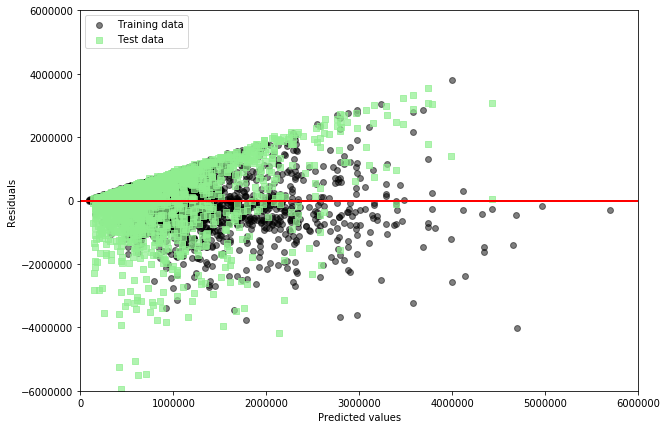

In [24]:
# matplotlibを呼び出して予測値との残差を散布図に可視化
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10, 7))
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 6000000, lw = 2, color = 'red')
plt.xlim([0, 6000000])
plt.ylim([-6000000, 6000000])
plt.show()

In [25]:
# 決定木の数を3,10,100,1000,10000に変えてグリッドサーチする
## 必要なライブラリのインポート
from sklearn.grid_search import GridSearchCV
## 動かすパラメータを明示的に表示、今回は決定木の数を変えてみる
params = {'n_estimators'  : [3, 10, 100, 1000, 10000], 'n_jobs': [-1]}

/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [26]:
# [注意]めちゃくちゃ実行時間かかります！！！
## モデルにインスタンス生成
mod = RandomForestRegressor()
## ハイパーパラメータ探索
cv = GridSearchCV(mod, params, cv = 10, scoring= 'mean_squared_error', n_jobs =1)
cv.fit(X_train, y_train)

/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mea

/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/arakei/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mea

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [3, 10, 100, 1000, 10000], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [27]:
# 予測値を計算
y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)
# MSE(平均二乗誤差)の計算
from sklearn.metrics import mean_squared_error
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)) )
# R^2(決定係数)の計算
from sklearn.metrics import r2_score
print('MSE train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)) )

MSE train : 341196869198.470, test : 984736998094.415
MSE train : 0.602, test : -0.091


In [28]:
print(cv.best_score_)  # 最も良かったスコア
print(cv.best_params_)  # 上記を記録したパラメータの組み合わせ

-884784031341.3314
{'n_estimators': 10000, 'n_jobs': -1}


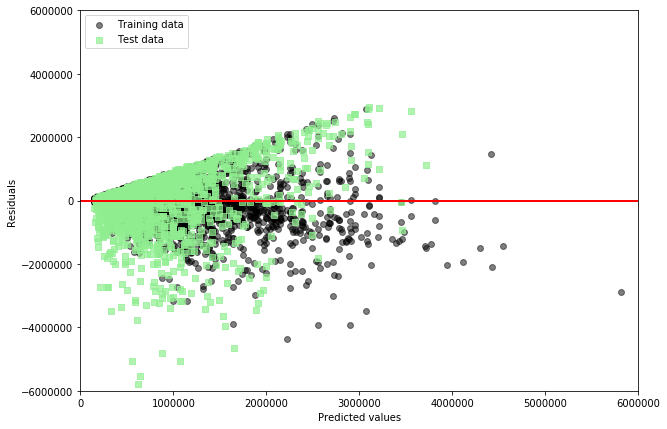

In [29]:
# matplotlibを呼び出して予測値との残差を散布図に可視化
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10, 7))
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 6000000, lw = 2, color = 'red')
plt.xlim([0, 6000000])
plt.ylim([-6000000, 6000000])
plt.show()